In [42]:
import pandas as pd
import seaborn as sns
from scipy import signal
from wormimtools.utils import interp1d
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from utils.utils import *
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM

In [43]:
def model_assumptions(model_fit, model_type='mixed'):
    # fig = plt.figure(figsize = (16, 9))
    # ax = sns.histplot(model_fit.resid, kde_kws = {"fill" : True, "lw": 1}, fit = stats.norm)
    # ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
    # ax.set_xlabel("Residuals")
    if model_type == 'mixed':
        residuals = model_fit.resid
    else: 
        residuals = model_fit.resid_pearson


    if model_type == 'mixed':
        ## Q-Q PLot
        fig = plt.figure(figsize = (16, 9))
        ax = fig.add_subplot(111)
        sm.qqplot(residuals, dist = stats.norm, line = 's', ax = ax)
        ax.set_title("Q-Q Plot")

    ## formally test for normality using Shapir-Wilk test of normality
    labels = ["Statistic", "p-value"]
    norm_res = stats.shapiro(residuals)
    for key, val in dict(zip(labels, norm_res)).items():
        print(key, val)
        
    # HOMOSKEDASTICITY OF VARIANCE   
    ## RVF Plot (residuals versus fitted values)
    fig = plt.figure(figsize = (16, 9))
    ax = sns.scatterplot(y = residuals, x = model_fit.fittedvalues)
    ax.set_title("RVF Plot")
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residuals")

    ## boxplot
    # fig = plt.figure(figsize = (16, 9))
    # ax = sns.boxplot(x = model_fit.model.groups, y = model_fit.resid_pearson)
    # ax.set_title("Distribution of Residuals for Row_Sum by Sample_ID")
    # ax.set_ylabel("Residuals")
    # ax.set_xlabel("Sample_ID")


    ## formally test with the White’s Lagrange Multiplier Test for Heteroscedasticity
    from statsmodels.stats.diagnostic import het_white
    het_white_res = het_white(residuals, model_fit.model.exog)
    labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
    for key, val in dict(zip(labels, het_white_res)).items():
        print(key, val)

In [44]:
def round_with_padding(value, round_digits=3):
    return format(round(value,round_digits), "."+str(round_digits)+"f")

In [45]:
def create_model_table(model_fit, groups=['JUb66(RFP) in CeMbio', 'MK JUb66(RFP)', 'OP50(RFP)'], first_index=12):
    table = model_fit.conf_int()
    table['point_est'] = model_fit.params
    table['pvals'] = model_fit.pvalues
    table['data'] = table['point_est'].apply(round_with_padding, args=(3,)).astype('str') +\
        ' (' + table[0].apply(round_with_padding, args=(3,)).astype('str') + ', ' +\
        table[1].apply(round_with_padding, args=(3,)).astype('str') + ')' +'\n'\
        + 'p=' + table['pvals'].apply(round_with_padding, args=(3,)).astype('str')

    filt = table[first_index:-1]

    df = pd.DataFrame()
    df.index = groups
    for i in range(0, len(filt['data']), len(groups)):
        addition = filt['data'][i:i+len(groups)]
        addition.index = df.index
        df[f'Intestinal Ring {i // len(groups) + 2}'] = addition

    return df

In [46]:
df = load_and_clean()

In [47]:
df

,ID,diet,rep,stage,channel0_arr_vals_raw,channel1_arr_vals_raw,vals,vals2
0,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP,1,YL4,"[771, 771, 771, 771, 771, 771, 771, 771, 771, ...",NaN,"[771.0, 771.0, 771.0, 771.0, 771.0, 771.0, 771...",NaN
1,0cd9c930-d410-11ee-914e-7a9d3027ed35,JUB66_RFP,1,YL4,"[715, 771, 771, 771, 771, 815, 886, 771, 771, ...",NaN,"[715.0, 761.4208069356453, 771.0, 771.0, 771.0...",NaN
2,0cd9d344-d410-11ee-914e-7a9d3027ed35,JUB66_RFP,1,YL4,"[771, 771, 1112, 1230, 1168, 1352, 1360, 1270,...",NaN,"[771.0, 771.0, 1002.1613871290431, 1172.986995...",NaN
3,0cd9e5e6-d410-11ee-914e-7a9d3027ed35,JUB66_RFP,1,YL4,"[750, 771, 771, 771, 771, 771, 771, 771, 771, ...",NaN,"[750.0, 769.3824608202734, 771.0, 771.0, 771.0...",NaN
4,0cd9ef50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP,1,YL4,"[771, 985, 1028, 1019, 1024, 978, 1125, 1430, ...",NaN,"[771.0, 979.0060020006669, 1025.5911970656884,...",NaN
...,...,...,...,...,...,...,...,...
5,5e524d4a-c214-11ee-8d53-7a9d3027ed34,JUB66_RFP_IN_CEMBIO_ONTO_PA01_GFP,3,L4,"[748, 654, 669, 604, 668, 760, 769, 768, 673, ...","[515, 724, 656, 644, 744, 763, 762, 766, 770, ...","[748.0, 661.7105701900633, 666.5391797265755, ...","[515.0, 706.8562854284762, 667.1557185728576, ..."
6,5e524d5e-c214-11ee-8d53-7a9d3027ed34,JUB66_RFP_IN_CEMBIO_ONTO_PA01_GFP,3,L4,"[514, 519, 668, 558, 655, 767, 700, 697, 741, ...","[514, 514, 517, 515, 752, 734, 725, 771, 771, ...","[514.0, 522.4778259419807, 662.8649549849949, ...","[514.0, 514.0700233411137, 516.9066355451818, ..."
7,5e524d7c-c214-11ee-8d53-7a9d3027ed34,JUB66_RFP_IN_CEMBIO_ONTO_PA01_GFP,3,L4,"[680, 736, 724, 763, 771, 764, 771, 771, 771, ...","[771, 771, 771, 771, 771, 771, 1006, 798, 1680...","[680.0, 733.4231410470156, 725.1043681227076, ...","[771.0, 771.0, 771.0, 771.0, 771.0, 771.0, 941..."
8,5e524d9a-c214-11ee-8d53-7a9d3027ed34,JUB66_RFP_IN_CEMBIO_ONTO_PA01_GFP,3,L4,"[655, 703, 731, 654, 700, 746, 771, 741, 745, ...","[514, 568, 641, 533, 708, 714, 745, 681, 766, ...","[655.0, 699.1267089029676, 726.4811603867956, ...","[514.0, 563.6425475158386, 629.21873957986, 55..."


In [48]:
df_sect = generate_section_params(df)
df_sect['log_peaks'] = np.log(df_sect['peaks'] + 1)

In [49]:
df_sect

,ID,diet_and_channel,rep,sect,vals,row_sum,log_row_sum,peak_sum,log_peak_sum,avg_peak,peaks,log_peaks
0,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,1,"[771.0, 771.0, 771.0, 771.0, 771.0, 771.0, 771...",625206.841280,13.345838,48557.412471,10.790502,8092.902078,6,1.945910
1,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,2,"[1276.4224741580526, 1251.8996332110692, 1178....",451877.597866,13.021167,13574.626209,9.515958,13574.626209,1,0.693147
2,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,3,"[778.5458486162045, 898.1110370123395, 865.282...",362003.632878,12.799410,0.000000,0.000000,0.000000,0,0.000000
3,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,4,"[1375.095031677212, 1153.4871623874456, 979.59...",354253.506836,12.777768,3043.225075,8.020673,3043.225075,1,0.693147
4,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,5,"[1064.9756585528467, 1148.9036345448494, 1076....",681622.157386,13.432231,47790.675559,10.774586,11947.668890,4,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...
2605,5e524db8-c214-11ee-8d53-7a9d3027ed34,JUB66_RFP_IN_CEMBIO_ONTO_PA01_GFP_1,3,5,"[1027.6875625208402, 1023.3297765921975, 1019....",376822.685562,12.839530,7718.350450,8.951356,3859.175225,2,1.098612
2606,5e524db8-c214-11ee-8d53-7a9d3027ed34,JUB66_RFP_IN_CEMBIO_ONTO_PA01_GFP_1,3,6,"[1020.6852284094616, 941.6025341780598, 902.70...",421699.482494,12.952048,35149.375458,10.467362,3195.397769,11,2.484907
2607,5e524db8-c214-11ee-8d53-7a9d3027ed34,JUB66_RFP_IN_CEMBIO_ONTO_PA01_GFP_1,3,7,"[1076.1193731243611, 1270.064021340445, 1279.2...",357780.110704,12.787674,12499.299433,9.433428,6249.649717,2,1.098612
2608,5e524db8-c214-11ee-8d53-7a9d3027ed34,JUB66_RFP_IN_CEMBIO_ONTO_PA01_GFP_1,3,8,"[771.0, 806.2330776925755, 965.9909969989762, ...",328195.289096,12.701364,8935.730577,9.097813,2978.576859,3,1.386294


In [75]:
groups = ['JUB66_RFP_0', 'JUB66_RFP_IN_CEMBIO_0', 'OP50_RFP_0', 'MK_JUB66_RFP_IN_JUB66_0']
df_model1 = df_sect[df_sect['diet_and_channel'].isin(groups)]

In [51]:
glm_model1 = smf.glm('peaks ~ C(diet_and_channel, Treatment(reference="MK_JUB66_RFP_IN_JUB66_0")) + C(sect) + C(diet_and_channel, Treatment(reference="MK_JUB66_RFP_IN_JUB66_0"):C(sect)', family=sm.families.NegativeBinomial(alpha=1), data=df_model1)

In [52]:
glm_model_fit1 = glm_model1.fit()
glm_model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  peaks   No. Observations:                  990
Model:                            GLM   Df Residuals:                      954
Model Family:        NegativeBinomial   Df Model:                           35
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1678.8
Date:                Fri, 19 Apr 2024   Deviance:                       1472.3
Time:                        13:54:35   Pearson chi2:                 2.08e+03
No. Iterations:                    24   Pseudo R-squ. (CS):             0.5548
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       1.1735      0.209      5.617      0.000       0.764       1.583
C(diet_and_channel)[T.JUB66_RFP_IN_CEMBIO_0]                   -0.2053      0.299     -0.686      0.493      -0.792       0.382
C(diet_and_channel)[T.MK_JUB66_RFP_IN_JUB66_0]                 -1.5790      0.356     -4.431      0.000      -2.277      -0.881
C(diet_and_channel)[T.OP50_RFP_0]                              -1.1735      0.379     -3.096      0.002      -1.916      -0.431
C(sect)[T.2]                                                   -0.4638      0.306     -1.518      0.129      -1.063       0.135
C(sect)[T.3]                                                    0.0404      0.295      0.137      0.891      -0.537       0.618
C(sect)[T.4]                                                    0.3740      0.290      1.290      0.197      -0.194       0.942
C(sect)[T.5]                                                    0.6776      0.287      2.363      0.018       0.116       1.240
C(sect)[T.6]                                                    1.0088      0.284      3.550      0.000       0.452       1.566
C(sect)[T.7]                                                    0.9427      0.285      3.313      0.001       0.385       1.501
C(sect)[T.8]                                                    1.0163      0.284      3.577      0.000       0.459       1.573
C(sect)[T.9]                                                    0.8634      0.285      3.028      0.002       0.304       1.422
C(diet_and_channel)[T.JUB66_RFP_IN_CEMBIO_0]:C(sect)[T.2]       0.0834      0.437      0.191      0.849      -0.774       0.940
C(diet_and_channel)[T.MK_JUB66_RFP_IN_JUB66_0]:C(sect)[T.2]    -0.9225      0.640     -1.441      0.150      -2.178       0.333
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.2]                 -0.2293      0.586     -0.391      0.696      -1.378       0.919
C(diet_and_channel)[T.JUB66_RFP_IN_CEMBIO_0]:C(sect)[T.3]      -0.0791      0.424     -0.187      0.852      -0.909       0.751
C(diet_and_channel)[T.MK_JUB66_RFP_IN_JUB66_0]:C(sect)[T.3]    -1.4267      0.635     -2.246      0.025      -2.672      -0.182
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.3]                 -3.0361      1.112     -2.730      0.006      -5.216      -0.856
C(diet_and_channel)[T.JUB66_RFP_IN_CEMBIO_0]:C(sect)[T.4]      -0.1791      0.417     -0.430      0.667      -0.996       0.638
C(diet_and_channel)[T.MK_JUB66_RFP_IN_JUB66_0]:C(sect)[T.4]    -1.2903      0.571     -2.261      0.024      -2.409      -0.172
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.4]                 -0.9719      0.570     -1.705      0.088      -2.089       0.145
C(diet_and_

Statistic 0.6030507517302155
p-value 1.0281728599648661e-42
LM Statistic 16.02522061877123
LM-Test p-value 0.9975102130496298
F-Statistic 0.4484733454808576
F-Test p-value 0.997793382918148


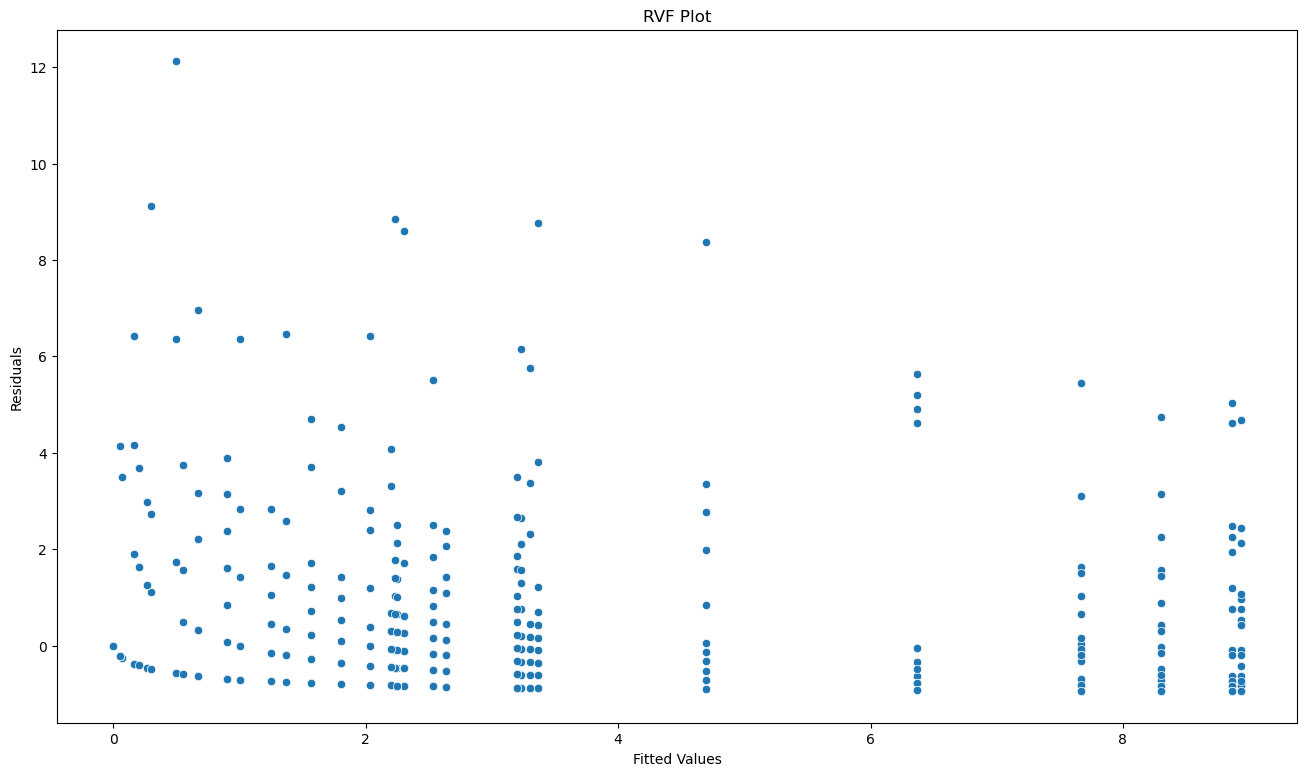

In [53]:
model_assumptions(glm_model_fit1, model_type='glm')

In [54]:
infl = glm_model_fit1.get_influence(observed=False)
summ_df = infl.summary_frame()
summ_df.sort_values("cooks_d", ascending=False)[:10]

,dfb_Intercept,dfb_C(diet_and_channel)[T.JUB66_RFP_IN_CEMBIO_0],dfb_C(diet_and_channel)[T.MK_JUB66_RFP_IN_JUB66_0],dfb_C(diet_and_channel)[T.OP50_RFP_0],dfb_C(sect)[T.2],dfb_C(sect)[T.3],dfb_C(sect)[T.4],dfb_C(sect)[T.5],dfb_C(sect)[T.6],dfb_C(sect)[T.7],...,dfb_C(diet_and_channel)[T.JUB66_RFP_IN_CEMBIO_0]:C(sect)[T.8],dfb_C(diet_and_channel)[T.MK_JUB66_RFP_IN_JUB66_0]:C(sect)[T.8],dfb_C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.8],dfb_C(diet_and_channel)[T.JUB66_RFP_IN_CEMBIO_0]:C(sect)[T.9],dfb_C(diet_and_channel)[T.MK_JUB66_RFP_IN_JUB66_0]:C(sect)[T.9],dfb_C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.9],cooks_d,standard_resid,hat_diag,dffits_internal
1921,-1.845856e-15,8.724653e-16,9.621880e-16,8.376807e-17,-1.351182e-16,-2.407978e-17,5.801309e-16,4.456976e-16,-2.166875e-16,7.655521e-16,...,4.349868e-17,6.248689e-17,-6.869009e-16,4.381945e-16,-1.422230e-18,4.039319e-17,0.145660,12.331625,0.033333,2.289925
1915,-4.418216e-16,-1.041799e-16,-4.453977e-16,-3.264068e-16,-2.191806e-16,-1.370887e-16,-3.947104e-16,1.610854e-17,-5.174409e-16,-2.151664e-16,...,-1.487746e-16,1.179610e+00,3.272072e-16,8.667915e-17,-2.135797e-18,5.350755e-17,0.082548,9.283338,0.033333,1.723873
1078,1.537778e-15,-3.188596e-17,-6.828876e-17,1.796217e-16,1.889695e-16,-1.473152e-16,-5.030516e-17,4.938793e-16,-2.402084e-16,-2.957077e-16,...,8.773045e-01,-2.238404e-16,-1.023434e-16,-2.558518e-19,2.961427e-20,-2.137267e-16,0.077510,8.995553,0.033333,1.670432
965,-3.570829e-16,-6.002470e-16,-5.086255e-16,3.044125e-16,6.486094e-16,1.168744e+00,-2.437591e-17,-3.374912e-16,1.281477e-16,-2.450832e-17,...,-3.968367e-16,-3.705748e-16,-1.835372e-17,3.907813e-16,-7.364416e-18,-1.768446e-17,0.076245,8.921882,0.033333,1.656752
1076,1.130827e-15,6.338247e-16,-1.467145e-16,2.425817e-16,3.480949e-16,3.383137e-16,2.641021e-16,3.922989e-16,2.502994e-16,-1.856177e-16,...,-2.781459e-16,7.777554e-17,-7.996802e-17,-3.905646e-17,4.927926e-18,1.894084e-16,0.073329,8.749618,0.033333,1.624763
984,-9.619603e-17,-6.095995e-16,-5.044596e-16,-3.626956e-16,-5.831394e-16,-6.924236e-16,1.095661e+00,-4.913779e-17,-2.051981e-16,-6.935381e-18,...,-7.905278e-17,2.658452e-16,4.975471e-16,5.181405e-16,3.922352e-17,1.363259e-16,0.069347,8.508699,0.033333,1.580026
504,-1.122309e-15,-3.102545e-16,-1.458390e-16,1.249819e+00,-4.719087e-16,-1.181002e-16,2.533823e-16,4.006021e-16,-5.793097e-16,-4.850467e-17,...,-6.202440e-16,-6.738740e-16,-9.409271e-01,7.216518e-16,1.003914e-17,-9.407203e-01,0.062327,6.529286,0.050000,1.497921
505,-1.052598e-15,-2.812543e-16,1.823279e-16,5.099063e-16,9.612041e-17,6.918179e-16,9.009721e-17,2.045426e-16,3.804863e-16,-3.467965e-16,...,5.144750e-18,-2.158695e-17,-1.804617e-16,7.049376e-17,3.318842e-18,-5.351593e-16,0.062070,6.515838,0.050000,1.494836
1917,-7.407737e-16,-2.693579e-16,1.064471e+00,3.019362e-16,-5.661159e-16,-8.749533e-16,4.019237e-17,-5.871562e-17,7.629142e-16,8.937275e-16,...,4.490209e-17,-6.829322e-01,-1.049929e-16,-2.701037e-16,-2.362025e-05,-6.142689e-16,0.047959,7.075943,0.033333,1.313970
1077,1.042242e-15,-2.392958e-18,1.139145e-16,1.670944e-16,-9.077638e-17,-8.158936e-17,-1.097840e-16,-2.042053e-17,-2.740472e-16,-1.682875e-16,...,-9.869357e-17,7.697223e-17,-2.469224e-16,6.771790e-17,1.927536e-19,-2.902528e-16,0.041460,6.579092,0.033333,1.221707


In [56]:
df_model1

,ID,diet_and_channel,rep,sect,vals,row_sum,log_row_sum,peak_sum,log_peak_sum,avg_peak,peaks,log_peaks
0,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,1,"[771.0, 771.0, 771.0, 771.0, 771.0, 771.0, 771...",625206.841280,13.345838,48557.412471,10.790502,8092.902078,6,1.945910
1,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,2,"[1276.4224741580526, 1251.8996332110692, 1178....",451877.597866,13.021167,13574.626209,9.515958,13574.626209,1,0.693147
2,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,3,"[778.5458486162045, 898.1110370123395, 865.282...",362003.632878,12.799410,0.000000,0.000000,0.000000,0,0.000000
3,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,4,"[1375.095031677212, 1153.4871623874456, 979.59...",354253.506836,12.777768,3043.225075,8.020673,3043.225075,1,0.693147
4,0cd9ae50-d410-11ee-914e-7a9d3027ed35,JUB66_RFP_0,1,5,"[1064.9756585528467, 1148.9036345448494, 1076....",681622.157386,13.432231,47790.675559,10.774586,11947.668890,4,1.609438
...,...,...,...,...,...,...,...,...,...,...,...,...
2245,0cdced86-d410-11ee-914e-7a9d3027ed35,OP50_RFP_0,3,5,"[771.0, 771.0, 771.0, 771.0, 771.0, 771.0, 771...",288334.445815,12.571876,0.000000,0.000000,0.000000,0,0.000000
2246,0cdced86-d410-11ee-914e-7a9d3027ed35,OP50_RFP_0,3,6,"[771.0, 771.0, 771.0, 771.0, 771.0, 771.0, 771...",308733.432144,12.640234,0.000000,0.000000,0.000000,0,0.000000
2247,0cdced86-d410-11ee-914e-7a9d3027ed35,OP50_RFP_0,3,7,"[838.502500833617, 1164.818939646531, 1480.554...",412684.527176,12.930439,35199.247416,10.468780,7039.849483,5,1.791759
2248,0cdced86-d410-11ee-914e-7a9d3027ed35,OP50_RFP_0,3,8,"[771.0, 771.0, 771.0, 771.0, 771.0, 771.0, 771...",302020.067689,12.618249,6523.034345,8.783095,3261.517172,2,1.098612


In [84]:
model1 = smf.ols('peaks ~ C(diet_and_channel, Treatment(reference="OP50_RFP_0")) + C(sect) + C(diet_and_channel, Treatment(reference="OP50_RFP_0")):C(sect)', data=df_model1)

In [85]:
model1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  peaks   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     5.135
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           3.36e-19
Time:                        14:18:08   Log-Likelihood:                -3188.3
No. Observations:                 990   AIC:                             6449.
Df Residuals:                     954   BIC:                             6625.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          1.0000      1.380      0.725      0.469      -1.709       3.709
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_0]                              2.2333      1.782      1.253      0.210      -1.263       5.730
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_IN_CEMBIO_0]                    1.6333      1.782      0.917      0.360      -1.863       5.130
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.MK_JUB66_RFP_IN_JUB66_0]                 -0.3333      1.782     -0.187      0.852      -3.830       3.163
C(sect)[T.2]                                                                                      -0.5000      1.952     -0.256      0.798      -4.331       3.331
C(sect)[T.3]                                                                                      -0.9500      1.952     -0.487      0.627      -4.781       2.881
C(sect)[T.4]                                                                                      -0.4500      1.952     -0.231      0.818      -4.281       3.381
C(sect)[T.5]                                                                                      -0.1000      1.952     -0.051      0.959      -3.931       3.731
C(sect)[T.6]                                                                                       0.2500      1.952      0.128      0.898      -3.581       4.081
C(sect)[T.7]                                                                                      -0.1000      1.952     -0.051      0.959      -3.931       3.731
C(sect)[T.8]                                                                                       1.2000      1.952      0.615      0.539      -2.631       5.031
C(sect)[T.9]                                                                                       1.2500      1.952      0.640      0.522      -2.581       5.081
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_0]:C(sect)[T.2]                -0.7000      2.520     -0.278      0.781      -5.645       4.245
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_IN_CEMBIO_0]:C(sect)[T.2]      -0.3333      2.520     -0.132      0.895      -5.279       4.612
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.MK_JUB66_RFP_IN_JUB66_0]:C(sect)[T.2]  -5.42e-15      2.520  -2.15e-15      1.000      -4.945       4.945
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_0]:C(sect)[T.3]                 1.0833      2.520      0.430      0.667      -3.86

In [71]:
vc = {'sect': '0 + C(sect)', 'diet_and_channel': '0+C(diet_and_channel)'}

In [86]:
mixed_model1 = smf.mixedlm('peaks ~ C(diet_and_channel, Treatment(reference="OP50_RFP_0")) + C(sect) + C(diet_and_channel, Treatment(reference="OP50_RFP_0")):C(sect)', data=df_model1, groups="ID")

In [87]:
model_fit1 = mixed_model1.fit()
#model_fit1_out = model_fit1.summary().as_text()

In [88]:
model_fit1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                  Mixed Linear Model Regression Results
=========================================================================================================================================
Model:                                       MixedLM                            Dependent Variable:                            peaks     
No. Observations:                            990                                Method:                                        REML      
No. Groups:                                  110                                Scale:                                         17.4307   
Min. group size:                             9                                  Log-Likelihood:                                -2906.6735
Max. group size:                             9                                  Converged:                                     Yes       
Mean group size:                             9.0                                                                                         
-----------------------------------------------------------------------------------------------------------------------------------------
                                                                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                       1.000    1.380  0.725 0.469 -1.705  3.705
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_0]                           2.233    1.782  1.253 0.210 -1.259  5.726
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_IN_CEMBIO_0]                 1.633    1.782  0.917 0.359 -1.859  5.126
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.MK_JUB66_RFP_IN_JUB66_0]              -0.333    1.782 -0.187 0.852 -3.826  3.159
C(sect)[T.2]                                                                                   -0.500    1.320 -0.379 0.705 -3.088  2.088
C(sect)[T.3]                                                                                   -0.950    1.320 -0.720 0.472 -3.538  1.638
C(sect)[T.4]                                                                                   -0.450    1.320 -0.341 0.733 -3.038  2.138
C(sect)[T.5]                                                                                   -0.100    1.320 -0.076 0.940 -2.688  2.488
C(sect)[T.6]                                                                                    0.250    1.320  0.189 0.850 -2.338  2.838
C(sect)[T.7]                                                                                   -0.100    1.320 -0.076 0.940 -2.688  2.488
C(sect)[T.8]                                                                                    1.200    1.320  0.909 0.363 -1.388  3.788
C(sect)[T.9]                                                                                    1.250    1.320  0.947 0.344 -1.338  3.838
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_0]:C(sect)[T.2]             -0.700    1.704 -0.411 0.681 -4.041  2.641
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_IN_CEMBIO_0]:C(sect)[T.2]   -0.333    1.704 -0.196 0.845 -3.674  3.007
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.MK_JUB66_RFP_IN_JUB66_0]:C(sect)[T.2]  0.000    1.704  0.000 1.000 -3.341  3.341
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_0]:C(sect)[T.3]              1.083    1.704  0.636 0.525 -2.257  4.424
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.JUB66_RFP_IN_CEMBIO_0]:C(sect)[T.3]    0.850    1.704  0.499 0.618 -2.491  4.191
C(diet_and_channel, Treatment(reference="OP50_RFP_0"))[T.MK_JUB66_RFP_IN_JUB66_0]:C(sect)[T.3]  0.450    1.704  0.264 0.792 -2.891  3.791

In [144]:
model_fit1.pvalues

Intercept                                                      3.763152e-12
C(diet_and_channel)[T.JUB66_RFP_IN_CEMBIO_0]                   2.454456e-01
C(diet_and_channel)[T.MK_JUB66_RFP_IN_JUB66_0]                 1.102090e-03
C(diet_and_channel)[T.OP50_RFP_0]                              1.081041e-02
C(sect)[T.2]                                                   6.790533e-02
C(sect)[T.3]                                                   3.369790e-01
C(sect)[T.4]                                                   7.596245e-01
C(sect)[T.5]                                                   3.467585e-01
C(sect)[T.6]                                                   5.434786e-01
C(sect)[T.7]                                                   1.251252e-01
C(sect)[T.8]                                                   7.423848e-03
C(sect)[T.9]                                                   2.754035e-02
C(diet_and_channel)[T.JUB66_RFP_IN_CEMBIO_0]:C(sect)[T.2]      7.918943e-01
C(diet_and_c

In [197]:
model1_df = create_model_table(model_fit1)

In [198]:
txt = model1_df.to_markdown()

In [199]:
with open('./output/table1.md', 'w') as f:
    f.write(txt)

In [95]:
mixed_model1_out = model_fit1.summary().as_text()
with open('./output/model1_out.txt', 'a') as f:
    f.write(mixed_model1_out)
    f.close()

Statistic 0.9923235405681741
p-value 5.1888539412504486e-05
LM Statistic 185.48819997329952
LM-Test p-value 2.3155075091511216e-07
F-Statistic 2.096213418266231
F-Test p-value 2.3510504959667963e-08


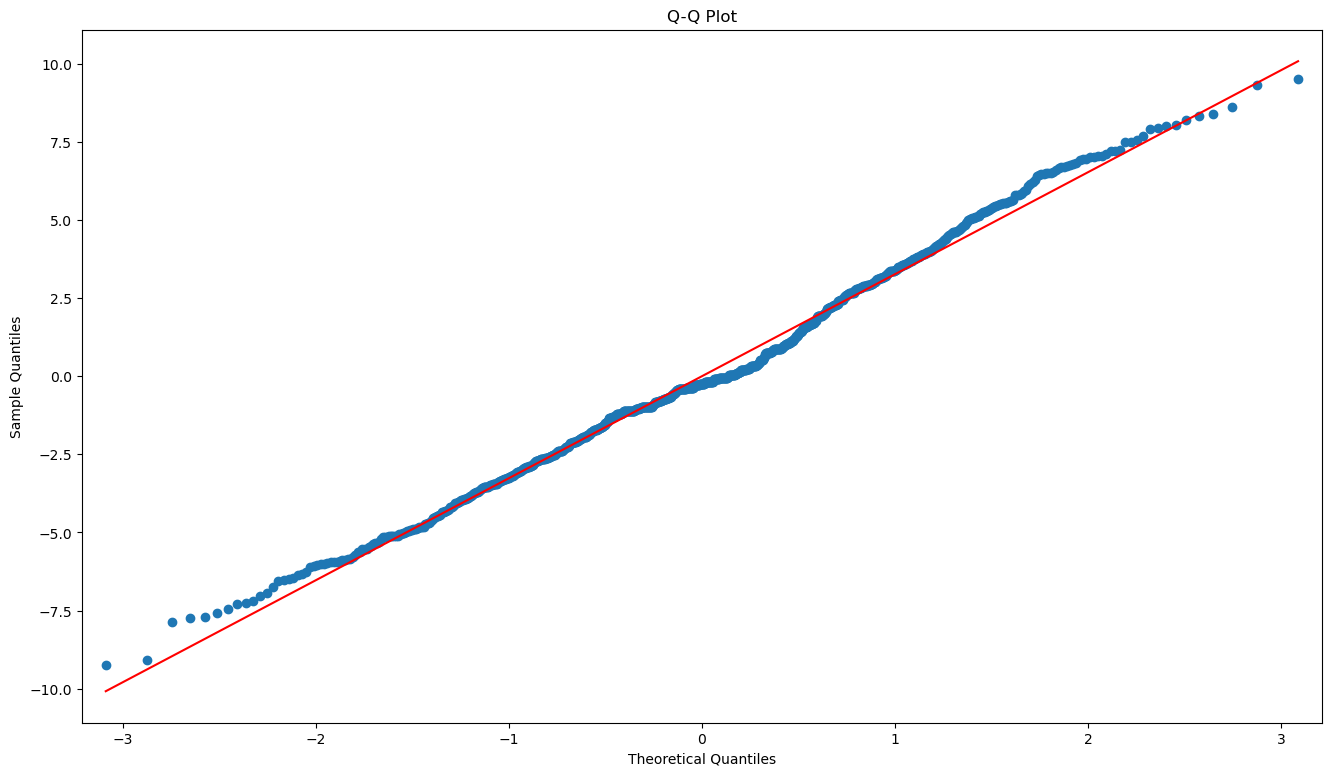

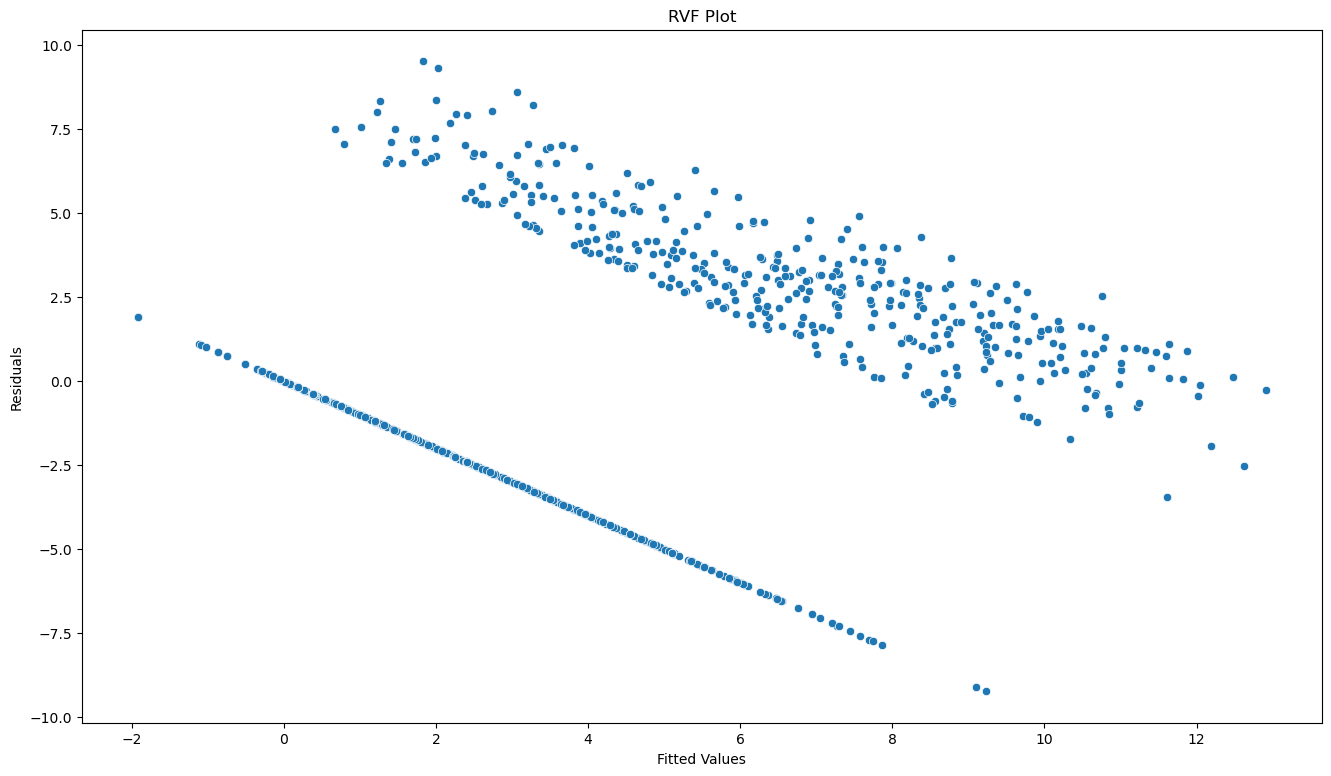

In [82]:
model_assumptions(model_fit1)

In [42]:
groups = ['JUB66_RFP_0', 'OP50_RFP_0', 'JUB66_RFP_ONTO_OP50_GFP_1']
df_model2 = df_sect[df_sect['diet_and_channel'].isin(groups)]

In [43]:
df_model2['diet_and_channel'].unique()

array(['JUB66_RFP_0', 'OP50_RFP_0', 'JUB66_RFP_ONTO_OP50_GFP_1'],
      dtype=object)

In [50]:
glm_model2 = smf.glm('peaks ~ C(diet_and_channel) + C(sect) + C(diet_and_channel):C(sect)', family=sm.families.NegativeBinomial(alpha=1), data=df_model2)
glm_model_fit2 = glm_model2.fit()

In [54]:
glm_model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  peaks   No. Observations:                  720
Model:                            GLM   Df Residuals:                      693
Model Family:        NegativeBinomial   Df Model:                           26
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1784.2
Date:                Thu, 18 Apr 2024   Deviance:                       1136.2
Time:                        09:11:45   Pearson chi2:                 1.23e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3742
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         1.1735      0.209      5.617      0.000       0.764       1.583
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]                  0.8052      0.286      2.819      0.005       0.245       1.365
C(diet_and_channel)[T.OP50_RFP_0]                                -1.1735      0.379     -3.096      0.002      -1.916      -0.431
C(sect)[T.2]                                                     -0.4638      0.306     -1.518      0.129      -1.063       0.135
C(sect)[T.3]                                                      0.0404      0.295      0.137      0.891      -0.537       0.618
C(sect)[T.4]                                                      0.3740      0.290      1.290      0.197      -0.194       0.942
C(sect)[T.5]                                                      0.6776      0.287      2.363      0.018       0.116       1.240
C(sect)[T.6]                                                      1.0088      0.284      3.550      0.000       0.452       1.566
C(sect)[T.7]                                                      0.9427      0.285      3.313      0.001       0.385       1.501
C(sect)[T.8]                                                      1.0163      0.284      3.577      0.000       0.459       1.573
C(sect)[T.9]                                                      0.8634      0.285      3.028      0.002       0.304       1.422
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.2]     0.2657      0.413      0.644      0.520      -0.543       1.074
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.2]                   -0.2293      0.586     -0.391      0.696      -1.378       0.919
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.3]    -0.3641      0.406     -0.898      0.369      -1.159       0.431
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.3]                   -3.0361      1.112     -2.730      0.006      -5.216      -0.856
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.4]    -0.4506      0.400     -1.125      0.260      -1.235       0.334
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.4]                   -0.9719      0.570     -1.705      0.088      -2.089       0.145
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.5]    -1.1158      0.401     -2.784      0.005      -1.901      -0.330
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.5]                   -0.7829      0.536     -1.459      0.144      -1.834       0.268
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.6]    -1.1004      0.396     -2.777      0.005      -1.877      -0.324
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.6]                   -0.7856      0.520     -1.51

Statistic 0.6887927007386307
p-value 2.3505045575793853e-34
LM Statistic 22.601278073903366
LM-Test p-value 0.6553934811451911
F-Statistic 0.8637970930006299
F-Test p-value 0.6620069999134727


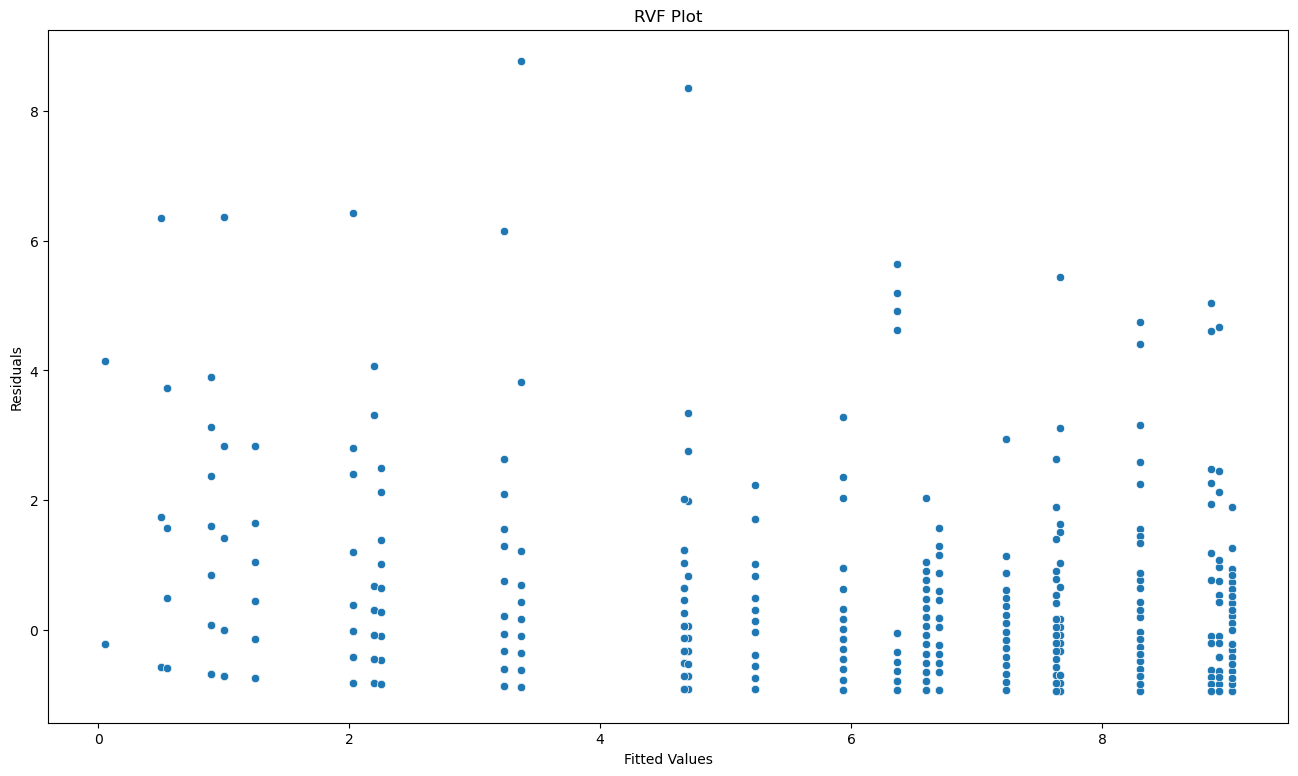

In [56]:
model_assumptions(glm_model_fit2, model_type='glm')

In [65]:
mixed_model2 = smf.mixedlm('np.log(peaks + 1) ~ C(diet_and_channel) + C(sect) + C(diet_and_channel):C(sect)', groups='ID', data=df_model2)
mixed_fit2 = mixed_model2.fit()

In [68]:
print(mixed_fit2.summary())

                                 Mixed Linear Model Regression Results
Model:                           MixedLM              Dependent Variable:              np.log(peaks + 1)
No. Observations:                720                  Method:                          REML             
No. Groups:                      80                   Scale:                           0.4981           
Min. group size:                 9                    Log-Likelihood:                  -872.2414        
Max. group size:                 9                    Converged:                       Yes              
Mean group size:                 9.0                                                                    
--------------------------------------------------------------------------------------------------------
                                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------

In [202]:
model2_df = create_model_table(mixed_fit2, groups = ['OP50(GFP) swapped from JUb66(RFP)', 'OP50(RFP)'], first_index=11)

In [203]:
txt2 = model2_df.to_markdown()
with open('./output/table2.md', 'w') as f:
    f.write(txt2)

In [97]:
mixed_model2_out = mixed_fit2.summary().as_text()

with open('./output/model2_out.txt', 'a') as f:
    f.write(mixed_model2_out)
    f.close()

In [106]:
mixed_fit2.params[11:-1].values

array([-0.05547849,  0.13654924, -0.16925286, -0.22275399, -0.12921138,
       -0.16506239, -0.27526598,  0.05055778, -0.39807365, -0.16942686,
       -0.45124331, -0.43159875, -0.53727812, -0.32201885, -0.61968857,
       -0.14146109])

In [118]:
mixed_fit2.conf_int()[11:-1]

,0,1
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.2],-0.560582,0.449625
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.2],-0.428174,0.701272
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.3],-0.674356,0.335851
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.3],-0.787477,0.341969
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.4],-0.634315,0.375892
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.4],-0.729785,0.399660
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.5],-0.780369,0.229837
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.5],-0.514165,0.615281
C(diet_and_channel)[T.JUB66_RFP_ONTO_OP50_GFP_1]:C(sect)[T.6],-0.903177,0.107030
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.6],-0.734150,0.395296


In [10]:
groups = ['OP50_RFP_0', 'JUB66_RFP_ONTO_OP50_GFP_1']
df_model3 = df_sect[df_sect['diet_and_channel'].isin(groups)]

In [11]:
mixed_model3 = smf.mixedlm('np.log(peaks + 1) ~ C(diet_and_channel) + C(sect) + C(diet_and_channel):C(sect)', groups='ID', data=df_model3)
mixed_fit3 = mixed_model3.fit()

In [29]:
mixed_fit3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                      MixedLM         Dependent Variable:         np.log(peaks + 1)
No. Observations:           450             Method:                     REML             
No. Groups:                 50              Scale:                      0.4541           
Min. group size:            9               Log-Likelihood:             -514.2726        
Max. group size:            9               Converged:                  Yes              
Mean group size:            9.0                                                          
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       1.770    0.153 11.531 0.000  1.469  2.070
C(diet_and_channel)[T.OP50_RFP_0]              -1.422    0.243 -5.858 0.000 -1.897 -0.946
C(sect)[T.2]                                   -0.333    0.174 -1.914 0.056 -0.674  0.008
C(sect)[T.3]                                   -0.260    0.174 -1.494 0.135 -0.601  0.081
C(sect)[T.4]                                   -0.062    0.174 -0.355 0.723 -0.403  0.279
C(sect)[T.5]                                   -0.288    0.174 -1.657 0.098 -0.629  0.053
C(sect)[T.6]                                   -0.053    0.174 -0.306 0.760 -0.394  0.288
C(sect)[T.7]                                    0.033    0.174  0.189 0.850 -0.308  0.374
C(sect)[T.8]                                    0.195    0.174  1.121 0.262 -0.146  0.536
C(sect)[T.9]                                   -0.025    0.174 -0.145 0.884 -0.366  0.316
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.2]  0.192    0.275  0.698 0.485 -0.347  0.731
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.3] -0.054    0.275 -0.194 0.846 -0.593  0.486
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.4] -0.036    0.275 -0.130 0.896 -0.575  0.503
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.5]  0.326    0.275  1.184 0.236 -0.213  0.865
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.6]  0.229    0.275  0.831 0.406 -0.311  0.768
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.7]  0.020    0.275  0.071 0.943 -0.520  0.559
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.8]  0.215    0.275  0.782 0.434 -0.324  0.754
C(diet_and_channel)[T.OP50_RFP_0]:C(sect)[T.9]  0.478    0.275  1.738 0.082 -0.061  1.017
ID Var                                          0.252    0.097                           
=========================================================================================

"""

In [34]:
txt = create_model_table(mixed_fit3, groups=['OP50(RFP)'], first_index=10)

In [35]:
txt = txt.to_markdown()

In [36]:
with open('./output/table3.md', 'w') as f:
    f.write(txt)

In [40]:
with open('./output/model3_out.txt', 'w') as f:
    f.write(mixed_fit3.summary().as_text())